##### *Задача*: Спрогназироваить отток клиентов в сети кофеен Starbucks.
##### *Проблема*: Отток клиентов ведет к потере выручку, однако своевременный прогноз клиентов, склонных к оттоку, позволит минимизировать потери.
##### *Цель*: Снизить уровень оттока клиентов, запустив таргетированные маркетенговые компании и индивидуальные программы лояльности для удержаня клинтов.

##### Будем использовать бинарную классификацию для предсказания реакции клента на маркетинговое предложение. Это позволит отсеить только тех клиентов, которые с наибольшей вероятностью примут предложение

## *Набор данных*  
Оценим данный [набор](https://www.kaggle.com/datasets/ihormuliar/starbucks-customer-data/data):

- **portfolio.csv** — информация о предложениях клиентам:
    - **id** — уникальный id предложения.
    - **offer_type** — тип предложения. *"bogo"* — купи одно, получи второе бесплатно; *"discount"* — скидка; *"informational"* — информационное предложение без вознаграждения.
    - **duration** — срок действия предложения.
    - **difficulty** — сумма, которую нужно потратить для активации данного предложения.
    - **channels** — как клиент получил предложение. *"email"* — эл. почта; *"mobile"* — уведомление в мобильном приложение; *"web"* — веб-сайт; *"social"* — соцсети.
    - **reward** — награда клиенту за выполнение условий предложения.

- **profile.csv** — информация о клиентах:
    - **id** — уникальный id клиента.
    - **gender** — пол клиента: *M* — мужчина, *F* — женщина, *NULL* — неизвестный пол.
    - **age** — возраст клиента.
    - **became_member_on** — дата регистрации клиента в программе лояльности
    - **income** — годовой доход клиента (USD).

- **transcript.csv** — взаимодействие клиентов с предложениями:
    - **person** — уникальный id клиента.
    - **event** — событие, связанное с предложением: *"offer received"* — предложение получено, *"offer viewed"* — предложение просмотрено, *"offer completed"* — предложение выполнено, *"transaction"* — совершена покупка.
    - **value** — дополнительная информация о событии
    - **time** — время с момента начала отслеживания, когда произошло событие.

### Целевые переменные

- **offer completed**: необходимо анализировать, какие клиенты завершили выполнение предложений.
- **income и age**: могут использоваться для кластеризации клиентов, анализа их предпочтений и разработки целевых предложений.
- **channels**: изучение влияния различных каналов на успешность предложений и отклик клиентов.

### EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
PROFILE = "./data/profile.csv"
PORTFOLIO = "./data/portfolio.csv"
TRANSCRIPT = "./data/transcript.csv"

profile_df = pd.read_csv(PROFILE)
portfolio_df = pd.read_csv(PORTFOLIO)
transcript_df = pd.read_csv(TRANSCRIPT)

In [15]:

print("Portfolio dataset:")
print(portfolio_df.head())

print("Profile dataset:")
print(profile_df.head())

print("Transcript dataset:")
print(transcript_df.head())

print("Portfolio data description:")
print(portfolio_df.describe(include="all"))

print("Profile data description:")
print(profile_df.describe(include="all"))

print("Transcript data description:")
print(transcript_df.describe(include="all"))

Portfolio dataset:
   Unnamed: 0  reward                              channels  difficulty  \
0           0      10         ['email', 'mobile', 'social']          10   
1           1      10  ['web', 'email', 'mobile', 'social']          10   
2           2       0            ['web', 'email', 'mobile']           0   
3           3       5            ['web', 'email', 'mobile']           5   
4           4       5                      ['web', 'email']          20   

   duration     offer_type                                id  
0         7           bogo  ae264e3637204a6fb9bb56bc8210ddfd  
1         5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0  
2         4  informational  3f207df678b143eea3cee63160fa8bed  
3         7           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4        10       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7  
Profile dataset:
   Unnamed: 0 gender  age                                id  became_member_on  \
0           0    NaN  118  68be06ca386d4c31939f3a4f0e3

### Рассмотрим распределения из эотго набора данных

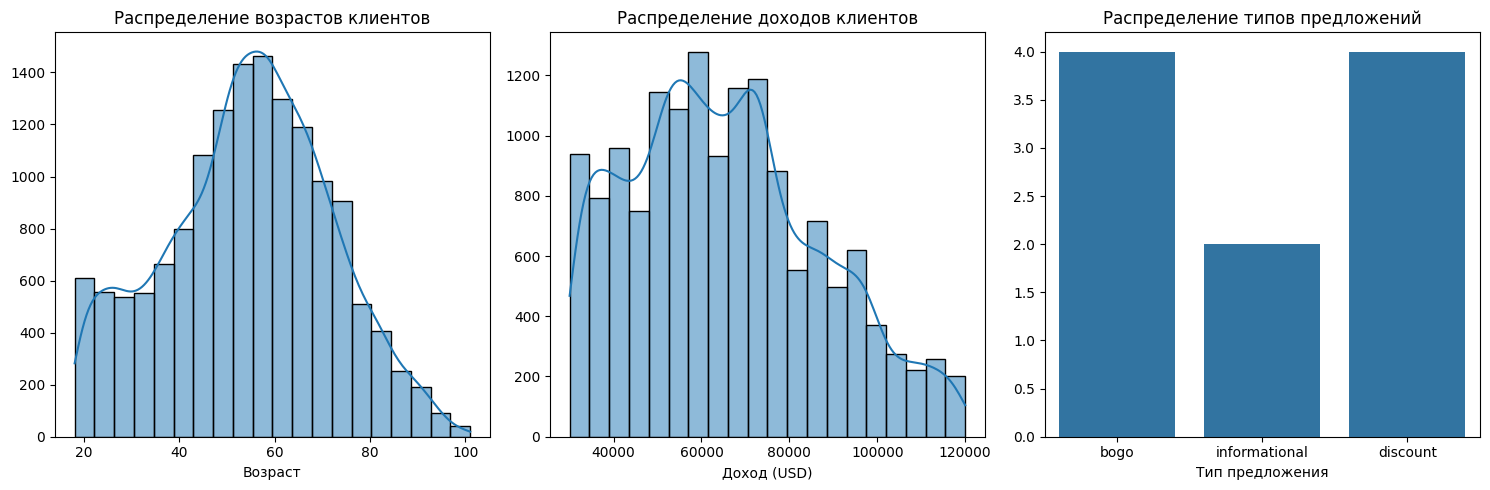

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(profile_df["age"].dropna()[profile_df["age"].dropna() < 110], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Распределение возрастов клиентов")
axes[0].set_xlabel("Возраст")
axes[0].set_ylabel("")

sns.histplot(profile_df["income"].dropna(), bins=20, kde=True, ax=axes[1])
axes[1].set_title("Распределение доходов клиентов")
axes[1].set_xlabel("Доход (USD)")
axes[1].set_ylabel("")

sns.countplot(x="offer_type", data=portfolio_df, ax=axes[2])
axes[2].set_title("Распределение типов предложений")
axes[2].set_xlabel("Тип предложения")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

Соберем все в одно, отфильтруем лишнее и выведем таргет

In [85]:
transcript_portfolio = transcript_df.merge(portfolio_df, left_on='value', right_on='id', suffixes=('_transcript', '_portfolio'), how='left')
combined_df = transcript_portfolio.merge(profile_df, left_on='person', right_on='id', suffixes=('', '_profile'), how='left')
combined_df = combined_df[['person', 'event', 'gender', 'age', 'income']]

combined_df = combined_df[combined_df["age"].dropna() < 110]
combined_df['target'] = combined_df['event'].apply(lambda x: 1 if x == 'offer completed' else 0)

print("\nРазмер объединенного DataFrame:", combined_df.size)
print(combined_df.head())

target = combined_df['target'].value_counts()
print("Удалось удержать:", target.get(1, 0))
print("Не удалось удержать:", target.get(0, 0))


Размер объединенного DataFrame: 1636572
                             person           event gender  age    income  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received      F   75  100000.0   
2  e2127556f4f64592b11af22de27a7932  offer received      M   68   70000.0   
5  389bc3fa690240e798340f5a15918d5c  offer received      M   65   53000.0   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received      M   58   51000.0   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received      F   61   57000.0   

   target  
0       0  
2       0  
5       0  
7       0  
8       0  
Удалось удержать: 32444
Не удалось удержать: 240318


Теперь будем учить модельку

In [71]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

In [100]:
# подготовим данные для обучения
X = combined_df[['gender', 'age', 'income']] # из-за плохого набора данных, выборка, вероятно, не репрезентативна
y = combined_df['target']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52, stratify=y)


In [101]:
model = CatBoostClassifier(iterations=1000, learning_rate=.003, depth=6, verbose=100, random_state=52)
model.fit(X_train, y_train)
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f'Точность на тренировочных данных: {train_accuracy:.2f}')
print(f'Точность на тестовых данных: {test_accuracy:.2f}')

0:	learn: 0.6201865	total: 15.8ms	remaining: 15.8s
100:	learn: 0.3595727	total: 913ms	remaining: 8.13s
200:	learn: 0.3588660	total: 1.88s	remaining: 7.49s
300:	learn: 0.3582370	total: 2.91s	remaining: 6.77s
400:	learn: 0.3577107	total: 3.87s	remaining: 5.79s
500:	learn: 0.3572925	total: 4.83s	remaining: 4.81s
600:	learn: 0.3568977	total: 5.81s	remaining: 3.86s
700:	learn: 0.3565504	total: 6.78s	remaining: 2.89s
800:	learn: 0.3562476	total: 7.81s	remaining: 1.94s
900:	learn: 0.3559555	total: 9.06s	remaining: 996ms
999:	learn: 0.3557050	total: 10.3s	remaining: 0us
Точность на тренировочных данных: 0.88
Точность на тестовых данных: 0.88


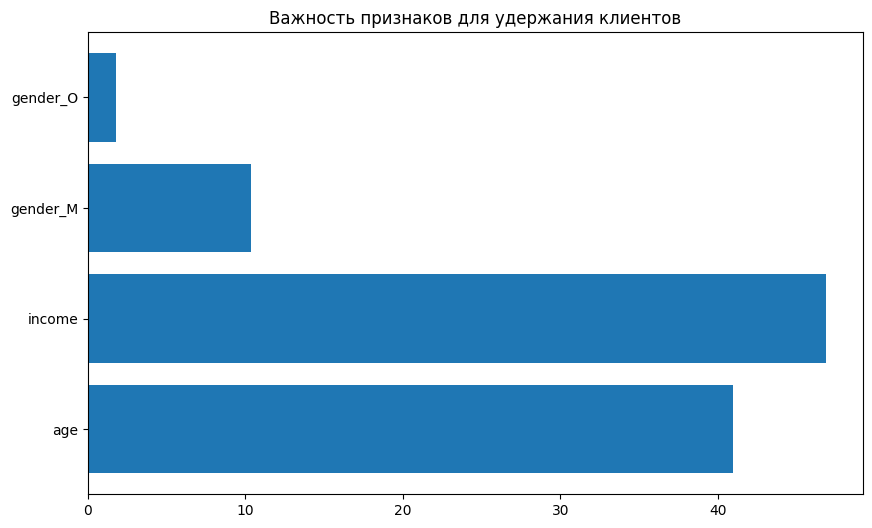

In [90]:
feature_importances = model.get_feature_importance()
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.title('Важность признаков для удержания клиентов')
plt.show()

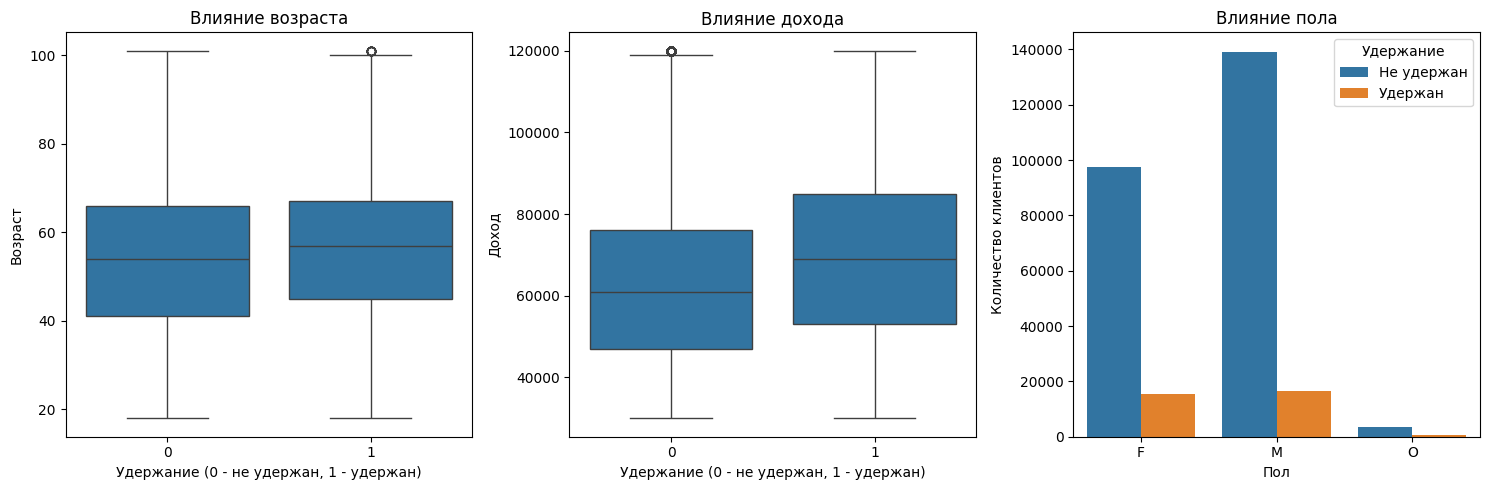

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='target', y='age', data=combined_df, ax=axes[0])
axes[0].set_title('Влияние возраста')
axes[0].set_xlabel('Удержание (0 - не удержан, 1 - удержан)')
axes[0].set_ylabel('Возраст')

sns.boxplot(x='target', y='income', data=combined_df, ax=axes[1])
axes[1].set_title('Влияние дохода')
axes[1].set_xlabel('Удержание (0 - не удержан, 1 - удержан)')
axes[1].set_ylabel('Доход')

sns.countplot(x='gender', hue='target', data=combined_df, ax=axes[2])
axes[2].set_title('Влияние пола')
axes[2].set_xlabel('Пол')
axes[2].set_ylabel('Количество клиентов')
axes[2].legend(title='Удержание', labels=['Не удержан', 'Удержан'])

plt.tight_layout()
plt.show()

In [99]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier


models = {
    'CatBoost': CatBoostClassifier(silent=True),
    'Random Forest': RandomForestClassifier(random_state=52),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=500)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1 Score': report['1']['f1-score']
    }

results_df = pd.DataFrame(results).T
print("Результаты моделей:\n", results_df)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metr

Результаты моделей:
                      Accuracy  Precision    Recall  F1 Score
CatBoost             0.881057   0.000000  0.000000   0.00000
Random Forest        0.881057   0.000000  0.000000   0.00000
KNN                  0.869814   0.112795  0.013768   0.02454
Logistic Regression  0.881057   0.000000  0.000000   0.00000


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
